# Sentiment Analysis Notebook 

In [1]:
# Utilities
from joblib import Parallel, delayed
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from multiprocessing import Pool, cpu_count
import warnings 
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress bar")
import gc
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Import time packages 
import time
import datetime

# Visualization Tools
import matplotlib.pyplot as plt

# Packages needed for text pre-processing:
import nltk 
import spacy 
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from spacy.language import Language
import re
import contractions
import emoji
from sklearn.preprocessing import MinMaxScaler
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Deep Learning Models 
import torch
import tensorflow as tf

# Sentiment Packages
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from scipy.special import softmax

import seaborn as sns 
import matplotlib.pyplot as plt 
# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set color palette to blue shades
sns.set_palette(["#003366", "#6699CC", "#99CCFF", "#99CCFF"])
sns.set_palette(["#002855", "#3E7EAA", "#82B5D8", "#B3D9F2"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("darkgrid")

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")
gc.collect()

97

---
### Vader Sentiment Analyzer

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing sentiment in social media texts. It returns four values:

- Positive score: A float value between 0.0 and 1.0 indicating the proportion of the text that is positive.
- Negative score: A float value between 0.0 and 1.0 indicating the proportion of the text that is negative.
- Neutral score: A float value between 0.0 and 1.0 indicating the proportion of the text that is neutral.
- Compound score: A float value between -1.0 and 1.0 indicating the overall sentiment of the text, where values closer to -1.0 indicate a very negative sentiment and values closer to 1.0 indicate a very positive sentiment. A compound score of 0.0 indicates a neutral sentiment.


The compound score is calculated by combining the positive, negative, and neutral scores in a way that reflects the intensity and polarity of the sentiment expressed in the text. The compound score is the most useful metric for assessing the overall sentiment of a text.

Therefore, the expected output range for the positive, negative, and neutral scores from VADER Sentiment Analyzer is 0.0 to 1.0, and the expected output range for the compound score is -1.0 to 1.0.

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()
def VaderSenti(text: str):
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_results = list(vader_scores.values())
    result_series =  pd.Series({'Vader_neg': vader_results[0], 'Vader_neut': vader_results[1], 'Vader_pos': vader_results[2], 'Vader_sentim': vader_results[3]})
    return result_series

In [4]:
pos_text = "Apple latest revenue reports have increased share price"
neg_text = "Apple latest revenue reports have decreased share price"

In [5]:
VaderSenti("The bank earned 30% more money")

Vader_neg       0.0
Vader_neut      1.0
Vader_pos       0.0
Vader_sentim    0.0
dtype: float64

---
## FinBert Modelling

FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification. Financial PhraseBank by Malo et al. (2014) is used for fine-tuning.

Negative score: A float value between 0.0 and 1.0 indicating the probability of the text expressing negative sentiment.

Positive score: A float value between 0.0 and 1.0 indicating the probability of the text expressing positive sentiment.
The sum of the negative and positive scores is always equal to 1.0.

Therefore, the expected output range for the negative and positive scores from the FinBERT model is 0.0 to 1.0, where larger values indicate a higher probability of the input text expressing negative or positive sentiment, respectively. The scores are probabilities, so their magnitudes are always between 0.0 and 1.0.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
def FinBertSenti(text: str): 
    with tf.device('/device:GPU:0'):
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probs = softmax(scores)
        pos_prob, neg_prob, neu_prob = probs
        sentiment_label = [1, -1, 0][probs.argmax()]
        result_series =  pd.Series({'Finbert_sentim_label': sentiment_label, 'Finbert_pos_prob': pos_prob, 'Finbert_neg_prob': neg_prob,'Finbert_neut_prob': neu_prob})
        return result_series

In [7]:
text = "Stocks rallied and the British pound gained."

In [8]:
FinBertSenti(text)

Finbert_sentim_label    1.000000
Finbert_pos_prob        0.898361
Finbert_neg_prob        0.034474
Finbert_neut_prob       0.067165
dtype: float64

---
## TextBlob

- Polarity is a float value within the range of -1.0 to 1.0, where -1.0 indicates a very negative sentiment and 1.0 indicates a very positive sentiment. A polarity value of 0.0 indicates a neutral sentiment.

- Subjectivity is a float value within the range of 0.0 to 1.0, where 0.0 indicates a very objective text and 1.0 indicates a very subjective text.

- Therefore, the expected output range for polarity is -1.0 to 1.0, and the expected output range for subjectivity is 0.0 to 1.0.

In [9]:
from textblob import TextBlob
def TextBlobSenti(text: str):
    TextBlobSenti = TextBlob(text).sentiment.polarity
    TextBlobObjecti = TextBlob(text).sentiment.subjectivity
    result_series =  pd.Series({'TextBlob_sentim': TextBlobSenti, 'TextBlob_objecti': TextBlobObjecti})
    return result_series

In [10]:
TextBlobSenti("I love pizza and i love you")

TextBlob_sentim     0.5
TextBlob_objecti    0.6
dtype: float64

---
## Compiled Sentiment Models

In [11]:
def sentiment_analyzer(df, sent_col: str):
    
    # 1. Performing FinBert Sentiment   
    with tf.device('/device:GPU:0'):
        df[["Finbert_sentim", "Finbert_pos", "Finbert_neg", "Finbert_neut"]] = df[sent_col].parallel_apply(lambda text:FinBertSenti(str(text)))
                
    # 2. TextBlob Sentiment Subjectivity 
    df[["Textblob_senti", "Textblob_obj"]] = df[sent_col].parallel_apply(lambda text:TextBlobSenti(str(text)))
    
    # 3. Perform VADER sentiment analysis
    df[["Vader_neg", "Vader_neut", "Vader_pos", "Vader_sentim"]] = df[sent_col].parallel_apply(lambda text: VaderSenti(str(text)))
                                                            
    return df   

---
## Twitter Data - Sentiment Analysis 

In [12]:
cleaned_tweets_df = pd.read_csv(twitter_data_path+ "/cleaned_tweets_df.csv")
cleaned_tweets_df["datetime"] = pd.to_datetime(cleaned_tweets_df["datetime"])
cleaned_tweets_df.head()

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company,cleaned_text
0,2017-01-01 00:04:53+00:00,MacHashNews,Review: Bragi's Headphone offers a solid alter...,Review: Bragi's Headphone offers a solid alter...,0.0,0.0,2.0,NaN,NaN,apple,review 's headphone offers a solid alternative...
1,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,tesla,analyst activity robert w. baird reiterates to...
2,2017-01-01 00:14:25+00:00,helpYOUgetGAINS,Roasted Persian Chicken and Cauliflower | Mark...,Roasted Persian Chicken and Cauliflower | Mark...,0.0,0.0,0.0,NaN,NaN,apple,roasted persian chicken and cauliflower | mark...
3,2017-01-01 00:38:06+00:00,jhamby,Apple also integrated DTrace into macOS and wr...,Apple also integrated DTrace into macOS and wr...,0.0,0.0,0.0,NaN,NaN,apple,apple also integrated into macos and wrote som...
4,2017-01-01 00:54:59+00:00,HuffPost,Google combats Holocaust-denying search result...,Google combats Holocaust-denying search result...,151.0,10.0,63.0,NaN,NaN,google,google combats holocaust denying search result...


In [13]:
#pandarallel.initialize(progress_bar=True)

In [14]:
# iter_save = 20000
# try: 
#     twitter_tweet_tweet_senti_df = pd.read_csv(twitter_data_path +"/twitter_senti_raw_df.csv")
#     with tf.device('/device:GPU:0'):
#         for i in tqdm(range(0, len(cleaned_tweets_df), iter_save)):
#             temp = cleaned_tweets_df.iloc[i:i+iter_save]
#             senti_temp = sentiment_analyzer(temp, "text")
#             twitter_senti_df = pd.concat([twitter_senti_df,senti_temp])
#             twitter_senti_df.to_csv(twitter_data_path + "/twitter_senti_raw_df.csv", index = False)
# except:
#     #print(e)
#     twitter_senti_df.to_csv(twitter_data_path + "/twitter_senti_raw_df.csv", index = False)
#     print("Stopped at iteration {}".format(i/iter_save))  #214.02s/it

---
## Reuters Data - Sentiment Analysis

In [15]:
eikon_news_df = pd.read_csv(eikon_data_path + "/cleaned_eikon_news_df.csv")
eikon_news_df["datetime"] = pd.to_datetime(eikon_news_df["datetime"])
#eikon_news_df = eikon_news_df.sort_values(by = "datetime", ascending = True).reset_index(drop = True)
eikon_news_df.head()

,datetime,source,stock,text,company,cleaned_text
0,2017-01-01 12:44:28,ZOLCOM,AAPL.OQ,Apple Inc. (AAPL) Sees Large Drop in Short Int...,apple,apple inc apple sees large drop in short interest
1,2017-01-01 16:34:58,ZOLCOM,AAPL.OQ,"JLB & Associates Inc. Has $10,751,000 Position...",apple,"associates inc has $ 10,751,000 position in ap..."
2,2017-01-02 09:24:17,RTRS,.GDAXI .IBEX,German and French share indexes start 2017 on ...,apple,german and french share indexes start 2017 on ...
3,2017-01-02 09:52:42,RTRS,AAPL.O DLGS.DE,BUZZ-Dialog Semi: Falls on report Apple plans ...,apple,buzz dialog semi falls on report apple plans i...
4,2017-01-02 22:54:59,AMEBAN,TSLA.OQ,"Tesla Motors, Inc. (TSLA) Downgraded by Vetr Inc.",tesla,tesla motors inc tesla downgraded by inc


In [16]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [17]:
#raw_eikon_senti_df = sentiment_analyzer(eikon_news_df, "text")

In [18]:
#senti_quick_test.to_csv(twitter_data_path + "/quick_test.csv")

---
## Preparing Eikon and Twitter Sentiment Variables 

In [68]:
# Retrieving sentiment on raw text 
twitter_senti_raw_df = pd.read_csv(twitter_data_path +"/twitter_senti_raw_df.csv")
twitter_senti_raw_df["datetime"] = pd.to_datetime(twitter_senti_raw_df["datetime"])
twitter_senti_raw_df =twitter_senti_raw_df.sort_values(by = "datetime")

In [69]:
# Retrieving sentiment on cleaned text
twitter_senti_df = pd.read_csv(twitter_data_path +"/twitter_senti_df.csv")
twitter_senti_df["datetime"] = pd.to_datetime(twitter_senti_df["datetime"])
twitter_senti_df =twitter_senti_df.sort_values(by = "datetime")
twitter_senti_df = twitter_senti_df.drop_duplicates()

In [70]:
# Retrieving Sentiment on Eikon Raw News 
eikon_senti_df = pd.read_csv(eikon_data_path +"/raw_eikon_senti_df.csv")
eikon_senti_df["datetime"] = pd.to_datetime(eikon_senti_df["datetime"])
eikon_senti_df =eikon_senti_df.sort_values(by = "datetime")

In [71]:
print(cleaned_tweets_df.shape)
print(twitter_senti_raw_df.shape)
print(twitter_senti_df.shape)
print(eikon_senti_df.shape)

(2157988, 11)
(2157990, 21)
(2157988, 21)
(44423, 16)


In [72]:
cleaned_tweets_df.datetime.dt.day_name().value_counts()

datetime
Tuesday      387865
Wednesday    385878
Thursday     376579
Friday       346848
Monday       343058
Saturday     166083
Sunday       151677
Name: count, dtype: int64

In [73]:
eikon_senti_df.datetime.dt.day_name().value_counts()

datetime
Wednesday    9026
Thursday     8827
Tuesday      8635
Friday       7746
Monday       7096
Saturday     1983
Sunday       1110
Name: count, dtype: int64

In [25]:
# Tweets on Saturday and Sunday are moved to Monday in order to not losse any relevance
from utils import fix_dates
twitter_senti_raw_df["datetime"] = twitter_senti_raw_df["datetime"].progress_apply(lambda x: fix_dates(x))
twitter_senti_df["datetime"] = twitter_senti_df["datetime"].progress_apply(lambda x: fix_dates(x))
eikon_senti_df["datetime"] = eikon_senti_df["datetime"].progress_apply(lambda x: fix_dates(x))

progress bar: 100%|██████████| 44423/44423 [00:00<00:00, 233269.23it/s]


---
#### Preparing Twitter Sentiment Table 

In [26]:
def update_twitter_sentiment(df): 
    
    #df = df.fillna({'likeCount': 0.0, 'reply_count':'0.0', "retweet_count": 0.0, "view_count": 0.0}).fillna(0)
    df = df.fillna(0.0)
    df["tweet_weight"] = 1
    df["date"] = df.datetime.dt.date
    daytweets = pd.DataFrame(df.groupby(by=["date"])["text"].count())
    daytweets = daytweets.rename(columns={"text": "daytweets"})
    df = pd.merge(df, daytweets, left_on=pd.to_datetime(df["datetime"]).dt.date, right_on="date")
    
    df["rolling_mean_likes"] = df["likeCount"].rolling(10000, min_periods=1).mean()
    df["rolling_std_likes"] = df["likeCount"].rolling(10000, min_periods=1).std()
    
    df["rolling_mean_replies"] = df["reply_count"].rolling(10000, min_periods=1).mean()
    df["rolling_std_replies"] = df["reply_count"].rolling(10000, min_periods=1).std()
    
    df["rolling_mean_retweets"] = df["retweet_count"].rolling(10000, min_periods=1).mean()
    df["rolling_std_retweets"] = df["retweet_count"].rolling(10000, min_periods=1).std()
    
    df.loc[(df["likeCount"] >= df["rolling_mean_likes"]) &  (df["likeCount"] < (df["rolling_mean_likes"] + df["rolling_std_likes"])), "tweet_weight"] += 1
    df.loc[(df["likeCount"] >= (df["rolling_mean_likes"]+ df["rolling_std_likes"])) &  (df["likeCount"] < (df["rolling_mean_likes"] + df["rolling_std_likes"]*2)), "tweet_weight"] += 2
    df.loc[(df["likeCount"] >= (df["rolling_mean_likes"]+ df["rolling_std_likes"]*2)), "tweet_weight"] +=3
    
    df.loc[(df["reply_count"] >= df["rolling_mean_replies"]) &  (df["reply_count"] < (df["rolling_mean_replies"] + df["rolling_std_replies"])), "tweet_weight"] += 1
    df.loc[(df["reply_count"] >= (df["rolling_mean_replies"]+ df["rolling_std_replies"])) &  (df["reply_count"] < (df["rolling_std_replies"] + df["rolling_std_replies"]*2)), "tweet_weight"] += 2
    df.loc[(df["reply_count"] >= (df["rolling_mean_replies"]+ df["rolling_std_replies"]*2)), "tweet_weight"] +=3
    
    df.loc[(df["retweet_count"] >= df["rolling_mean_retweets"]) &  (df["retweet_count"] < (df["rolling_mean_retweets"] + df["rolling_std_retweets"])), "tweet_weight"] += 1
    df.loc[(df["retweet_count"] >= (df["rolling_mean_retweets"]+ df["rolling_std_retweets"])) &  (df["retweet_count"] < (df["rolling_mean_retweets"] + df["rolling_std_retweets"]*2)), "tweet_weight"] += 2
    df.loc[(df["retweet_count"] >= (df["rolling_mean_retweets"]+ df["rolling_std_retweets"]*2)), "tweet_weight"] +=3
    
    # Applying the tweet weight -----------------------------------------
    df["textblob_senti_tw"] = df["Textblob_senti"] *  df["tweet_weight"]
    df["vader_senti_tw"] = df["Vader_sentim"] *  df["tweet_weight"]
    df["finbert_senti_tw"] = df["Finbert_sentim"] *  df["tweet_weight"]

    # Applying Sentiment Weight -----------------------------------------
    df["finbert_sw"] = 1
    df.loc[(df["Finbert_pos"] > 0.90), "finbert_sw"] += 1
    df.loc[(df["Finbert_neg"] > 0.90), "finbert_sw"] += 1
    df.loc[(df["Finbert_neut"] > 0.90), "finbert_sw"] += 1
    df["finbert_senti_sw"] =  df["Finbert_sentim"] * df["finbert_sw"]
    
    df["textblob_sw"] = 1
    df.loc[(df["Textblob_obj"] > 0.65), "textblob_sw"] += 1
    df["textblob_senti_sw"] =  df["Textblob_senti"] * df["textblob_sw"]
    
    df["vader_sw"] = 1
    df.loc[(df["Vader_sentim"] > 0.7), "vader_sw"] += 1
    df.loc[(df["Vader_sentim"] < -0.7), "vader_sw"] += 1
    df["vader_senti_sw"] =  df["Vader_sentim"] * df["vader_sw"]
    
    # Combining weights -------------------------------------------------
    df["textblob_tw_sw"] = df["Textblob_senti"] *  (df["tweet_weight"] + df["textblob_sw"])
    df["vader_tw_sw"] = df["Vader_sentim"] *  (df["tweet_weight"] + df["vader_sw"])
    df["finbert_tw_sw"] = df["Finbert_sentim"] *  (df["tweet_weight"] + df["finbert_sw"])
    
    df = df.set_index(pd.to_datetime(df.datetime), drop= True)
    df = df.drop(columns="datetime")
    df = df.fillna(0.0)
    
    df2 = df[["date", "daytweets", 
               "textblob_tw_sw","vader_tw_sw","finbert_tw_sw",
               "textblob_senti_sw","vader_sw","finbert_senti_sw", 
               "textblob_senti_tw","vader_senti_tw","finbert_senti_tw",
               "Textblob_senti" ,"Vader_sentim", "Finbert_sentim"]]
    
    
    df2 = df2.groupby(by = ["date"]).sum()
    
    df2.insert(0, "company", df["company"].iloc[0])

    return df2

In [27]:
twitter_senti_df.groupby(["Finbert_sentim"])[["Finbert_pos","Finbert_neg","Finbert_neut"]].mean()

,Finbert_pos,Finbert_neg,Finbert_neut
Finbert_sentim,,,
-1.0,0.049131,0.789792,0.161077
0.0,0.096612,0.063593,0.839795
1.0,0.748641,0.053916,0.197443


In [28]:
tweet_senti_df = pd.DataFrame()
for comp in ["google", "tesla", "moderna", "apple"]:
    company = twitter_senti_df[twitter_senti_df["company"] == comp]
    temp = update_twitter_sentiment(company)
    tweet_senti_df = pd.concat([tweet_senti_df, temp])

In [29]:
tweet_senti_df.head()

,company,daytweets,textblob_tw_sw,vader_tw_sw,finbert_tw_sw,textblob_senti_sw,vader_sw,finbert_senti_sw,textblob_senti_tw,vader_senti_tw,finbert_senti_tw,Textblob_senti,Vader_sentim,Finbert_sentim
date,,,,,,,,,,,,,,
2017-01-02,google,32400,27.841547,4.7608,-50.0,11.939170,203,-23.0,15.902377,7.2756,-27.0,10.589599,1.0690,-20.0
2017-01-03,google,15876,19.047536,36.4611,-18.0,9.819791,135,-9.0,9.227745,16.5585,-9.0,8.590994,14.5385,-3.0
2017-01-04,google,15876,23.160931,26.8358,-33.0,9.844632,135,-17.0,13.316299,14.9871,-16.0,7.434632,9.3854,-5.0
2017-01-05,google,59536,35.943061,23.3183,-158.0,13.475675,250,-58.0,22.467386,12.3415,-100.0,13.589311,6.4165,-34.0
2017-01-06,google,13924,27.882372,25.2437,-21.0,13.904778,124,-10.0,13.977594,11.2470,-11.0,10.841192,12.5456,-3.0


---

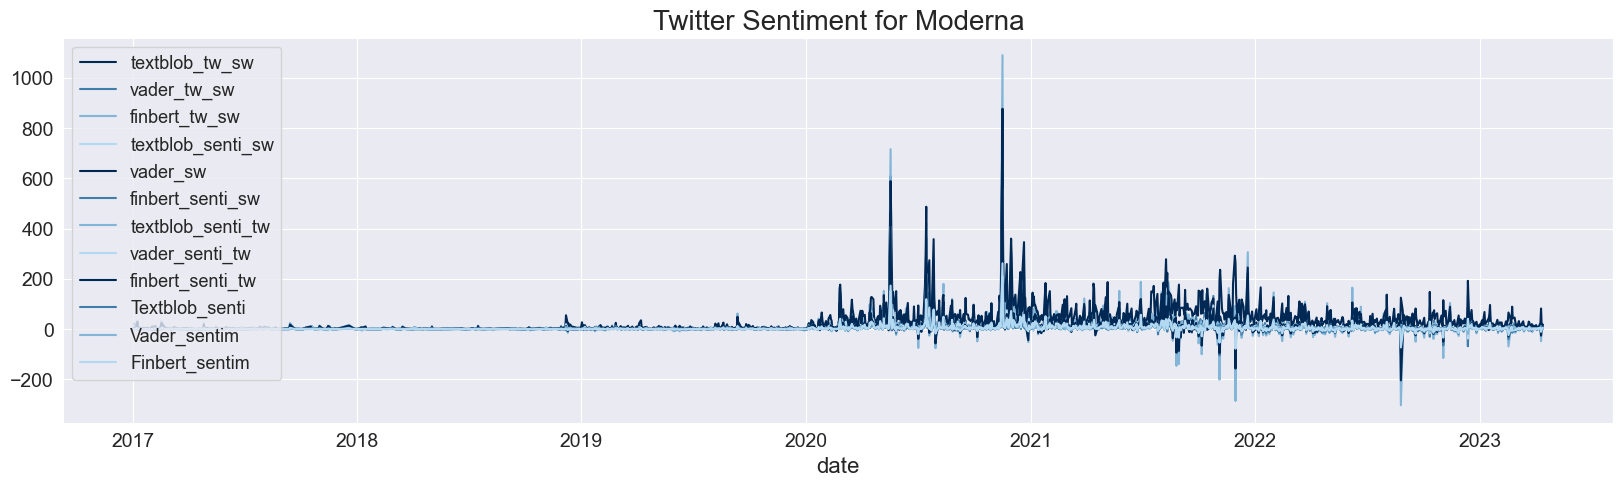

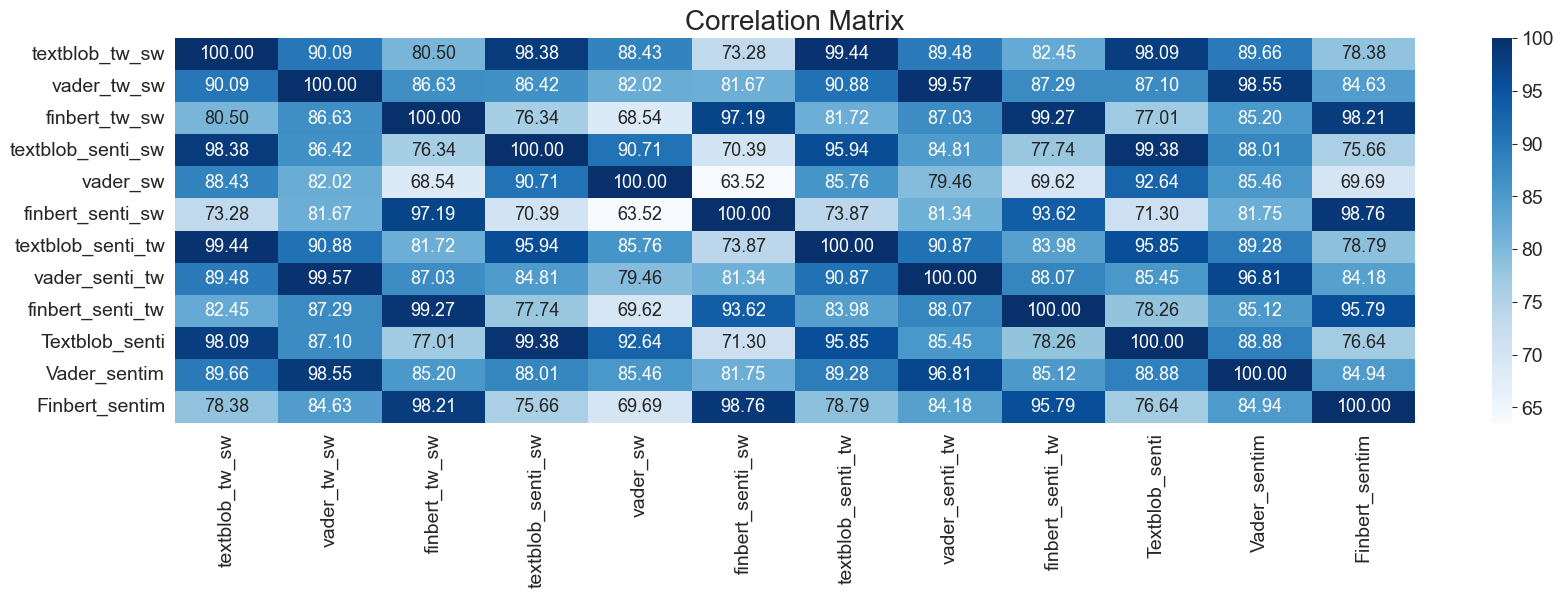

In [30]:
# Correlation for tesla between sentiment
twitter_test = tweet_senti_df[tweet_senti_df["company"] == "moderna"]
twitter_test = twitter_test.iloc[:,2:]
twitter_test.plot(figsize = (20,5), title = "Twitter Sentiment for Moderna")
plt.show()
corr_matrix = twitter_test.corr().abs()*100
corr_matrix = corr_matrix.round(2)
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---
## Tesla Sentiment Analysis 

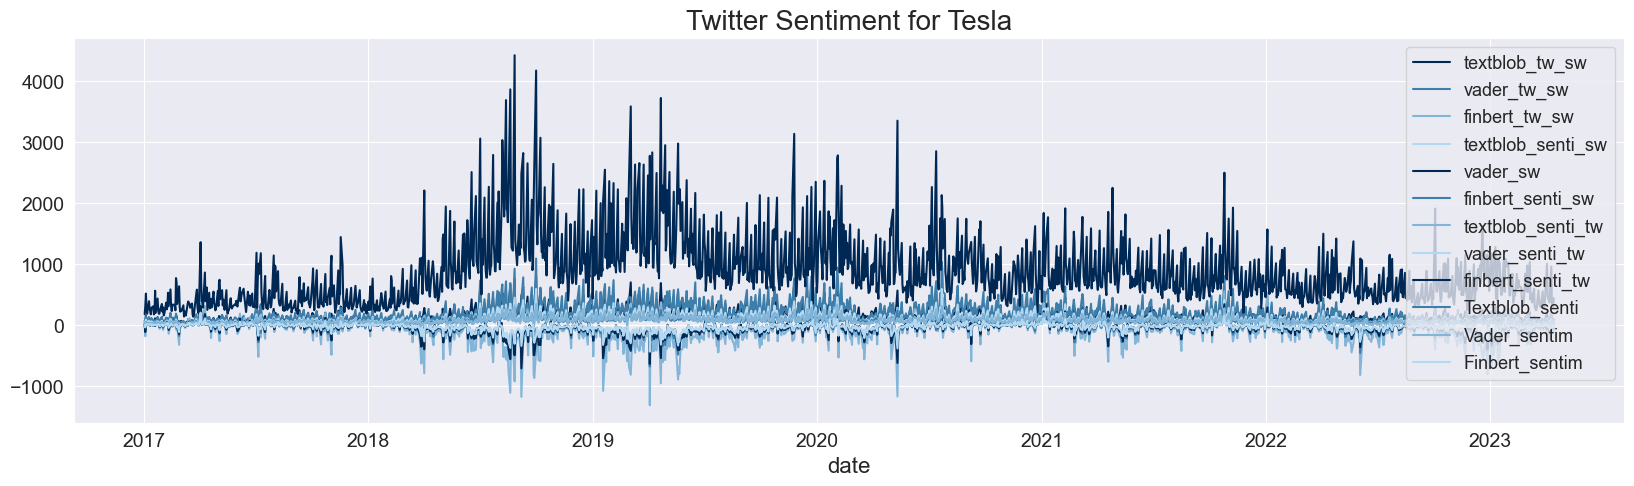

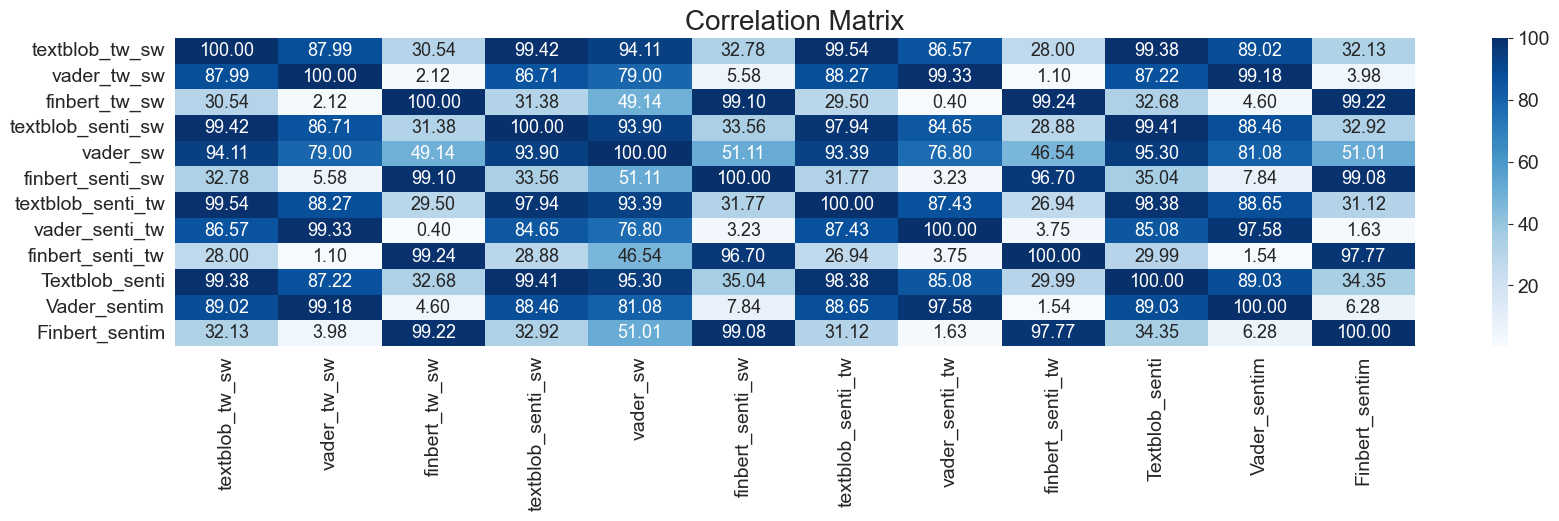

In [31]:
# Correlation for tesla between sentiment
twitter_test = tweet_senti_df[tweet_senti_df["company"] == "tesla"]
twitter_test = twitter_test.iloc[:,2:]
twitter_test.plot(figsize = (20,5), title = "Twitter Sentiment for Tesla")
plt.show()
corr_matrix = twitter_test.corr().abs()*100
corr_matrix = corr_matrix.round(2)
plt.figure(figsize=(20, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

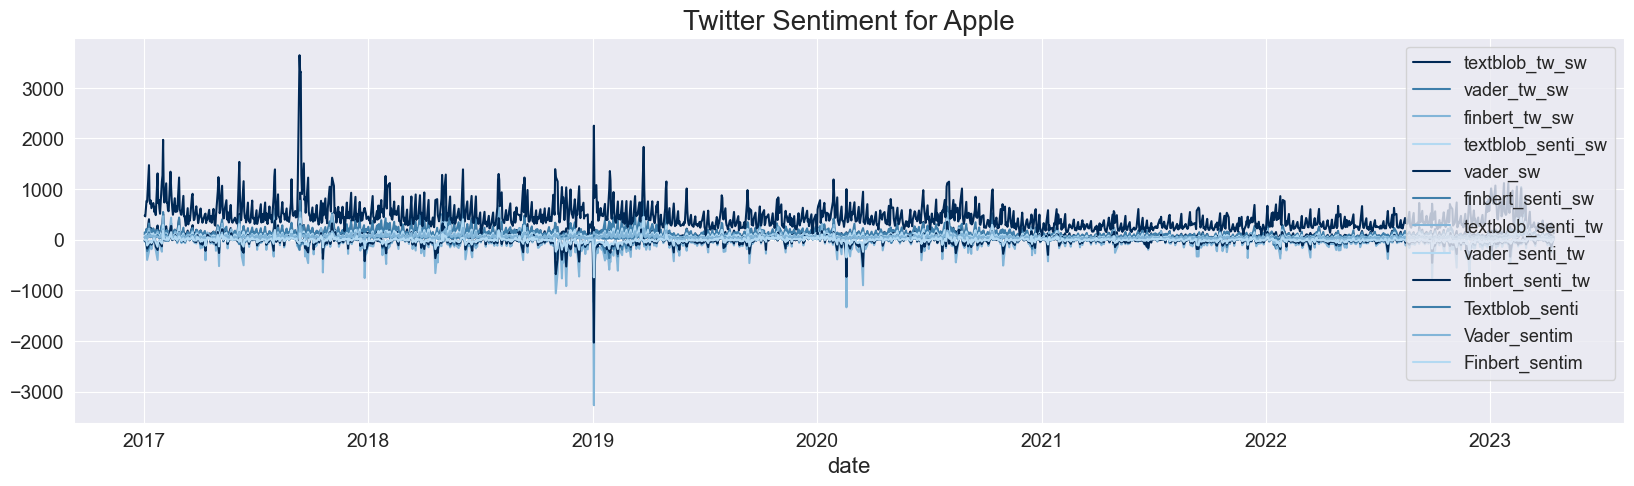

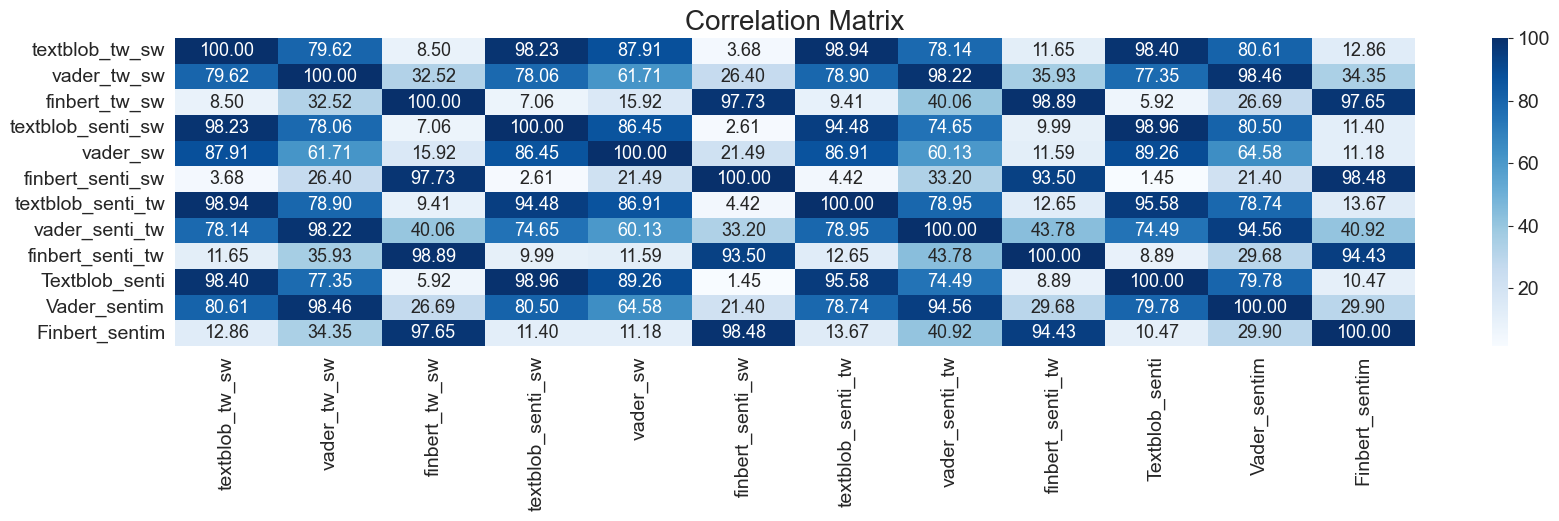

In [32]:
# Correlation for tesla between sentiment
twitter_test = tweet_senti_df[tweet_senti_df["company"] == "apple"]
twitter_test = twitter_test.iloc[:,2:]
twitter_test.plot(figsize = (20,5), title = "Twitter Sentiment for Apple")
plt.show()
corr_matrix = twitter_test.corr().abs()*100
corr_matrix = corr_matrix.round(2)
plt.figure(figsize=(20, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---
#### Preparing Eikon Sentiment Table 

In [33]:
def update_eikon_sentiment(df):
    
    df["date"] = df.datetime.dt.date
    df['news_count'] = df.groupby(['date', 'company'])['text'].transform('count')
    # TextBlob Sentiment with higher confidence should be weighted higher as well 
    df["textblob_sw"] = 1
    df.loc[(df["Textblob_obj"] > 0.65), "textblob_sw"] += 1
    df["eik_textblob_senti_sw"] =  df["Textblob_senti"] * df["textblob_sw"]
  
    # Addign weighting for finbert 
    df["finbert_sw"] = 1
    df.loc[(df["Finbert_pos"] > 0.90), "finbert_sw"] += 1
    df.loc[(df["Finbert_neg"] > 0.90), "finbert_sw"] += 1
    df.loc[(df["Finbert_neut"] > 0.90), "finbert_sw"] += 1
    df["eik_finbert_senti_sw"] =  df["Finbert_sentim"] * df["finbert_sw"]
    
    # Adding finbert weighting 
    df["vader_sw"] = 1
    df.loc[(df["Vader_sentim"] > 0.7), "vader_sw"] += 1
    df.loc[(df["Vader_sentim"] < -0.7), "vader_sw"] += 1
    df["eik_vader_senti_sw"] =  df["Vader_sentim"] * df["vader_sw"]

    df = df.drop(columns="datetime")
    df = df.groupby(by = ["date", "company"]).sum()
    df = df.reset_index()
    df = df.rename(columns = {"Finbert_sentim": "eik_Finbert_sentim", "Textblob_senti":"eik_Textblob_senti", "Vader_sentim": "eik_Vader_sentim"})
    df = df[["date","company","news_count","eik_textblob_senti_sw", "eik_finbert_senti_sw","eik_vader_senti_sw", "eik_Finbert_sentim", "eik_Textblob_senti", "eik_Vader_sentim"]]
    return df 

In [34]:
final_eikon_senti_df = update_eikon_sentiment(eikon_senti_df)

In [35]:
final_eikon_senti_df.head(3)

,date,company,news_count,eik_textblob_senti_sw,eik_finbert_senti_sw,eik_vader_senti_sw,eik_Finbert_sentim,eik_Textblob_senti,eik_Vader_sentim
0,2017-01-02,apple,16,0.107143,-6.0,-0.2248,-3.0,0.107143,-0.2248
1,2017-01-02,tesla,1,0.000000,-1.0,0.0000,-1.0,0.000000,0.0000
2,2017-01-03,apple,4,0.000000,0.0,0.0000,0.0,0.000000,0.0000


---
### Overall Sentiment Correlation

In [41]:
# Overall Sentiment Correlation
final_eikon_senti_df[["eik_Finbert_sentim", "eik_Textblob_senti", "eik_Vader_sentim"]].corr().round(2)*100

,eik_Finbert_sentim,eik_Textblob_senti,eik_Vader_sentim
eik_Finbert_sentim,100.0,13.0,53.0
eik_Textblob_senti,13.0,100.0,41.0
eik_Vader_sentim,53.0,41.0,100.0


In [42]:
# Overall Sentiment Correlation
final_eikon_senti_df[["eik_finbert_senti_sw", "eik_textblob_senti_sw", "eik_vader_senti_sw"]].corr().round(2)*100

,eik_finbert_senti_sw,eik_textblob_senti_sw,eik_vader_senti_sw
eik_finbert_senti_sw,100.0,12.0,48.0
eik_textblob_senti_sw,12.0,100.0,39.0
eik_vader_senti_sw,48.0,39.0,100.0


---
### Correlation between Eikon and Twitter News

In [59]:
tweet_senti_df_final = tweet_senti_df.reset_index()
tweet_senti_df_final["date"] = pd.to_datetime(tweet_senti_df_final["date"])
tweet_senti_df_final = tweet_senti_df_final.sort_values(by = ["date", "company"])
tweet_senti_df_final.shape

(6216, 15)

In [60]:
final_eikon_senti_df["date"] = pd.to_datetime(final_eikon_senti_df["date"])
final_eikon_senti_df = final_eikon_senti_df.sort_values(by = ["date", "company"])
final_eikon_senti_df.shape

(3931, 9)

In [61]:
master_table_news_sentiment = pd.merge(tweet_senti_df_final, final_eikon_senti_df, how = "outer", on = ["date", "company"])
master_table_news_sentiment = master_table_news_sentiment.fillna(0.0)
master_table_news_sentiment.shape

(6216, 22)

In [62]:
master_table_news_sentiment.columns

Index(['date', 'company', 'daytweets', 'textblob_tw_sw', 'vader_tw_sw',
       'finbert_tw_sw', 'textblob_senti_sw', 'vader_sw', 'finbert_senti_sw',
       'textblob_senti_tw', 'vader_senti_tw', 'finbert_senti_tw',
       'Textblob_senti', 'Vader_sentim', 'Finbert_sentim', 'news_count',
       'eik_textblob_senti_sw', 'eik_finbert_senti_sw', 'eik_vader_senti_sw',
       'eik_Finbert_sentim', 'eik_Textblob_senti', 'eik_Vader_sentim'],
      dtype='object')

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
textblob_tweets_scaler = MinMaxScaler()
textblob_eikon_scaler = MinMaxScaler()

finbert_tweets_scaler = MinMaxScaler()
finbert_eikon_scaler = MinMaxScaler()

vader_tweets_scaler = MinMaxScaler()
vader_eikon_scaler = MinMaxScaler()

# Normalize the columns
master_table_news_sentiment["textblob_tw_sw_norm"] = textblob_tweets_scaler.fit_transform(master_table_news_sentiment[["textblob_tw_sw"]])
master_table_news_sentiment["textblob_eik_sw_norm"] = textblob_eikon_scaler.fit_transform(master_table_news_sentiment[["eik_textblob_senti_sw"]])

master_table_news_sentiment["finbert_tw_sw_norm"] = finbert_tweets_scaler.fit_transform(master_table_news_sentiment[["finbert_tw_sw"]])
master_table_news_sentiment["finbert_eik_sw_norm"] = finbert_eikon_scaler.fit_transform(master_table_news_sentiment[["eik_finbert_senti_sw"]])

master_table_news_sentiment["vader_tw_sw_norm"] = vader_tweets_scaler.fit_transform(master_table_news_sentiment[["vader_tw_sw"]])
master_table_news_sentiment["vader_eik_sw_norm"] = vader_eikon_scaler.fit_transform(master_table_news_sentiment[["eik_vader_senti_sw"]])

# Calculate the weighted average
master_table_news_sentiment["textblob_eik_twi_senti"] = (master_table_news_sentiment["textblob_tw_sw_norm"] * 0.5 + master_table_news_sentiment["textblob_eik_sw_norm"] * 0.5) / 2
master_table_news_sentiment["finbert_eik_twi_senti"] = (master_table_news_sentiment["finbert_tw_sw_norm"] * 0.5 + master_table_news_sentiment["finbert_eik_sw_norm"] * 0.5) / 2
master_table_news_sentiment["vader_eik_twi_senti"] = (master_table_news_sentiment["vader_tw_sw_norm"] * 0.5 + master_table_news_sentiment["vader_eik_sw_norm"] * 0.5) / 2

In [64]:
master_table_news_sentiment.columns

Index(['date', 'company', 'daytweets', 'textblob_tw_sw', 'vader_tw_sw',
       'finbert_tw_sw', 'textblob_senti_sw', 'vader_sw', 'finbert_senti_sw',
       'textblob_senti_tw', 'vader_senti_tw', 'finbert_senti_tw',
       'Textblob_senti', 'Vader_sentim', 'Finbert_sentim', 'news_count',
       'eik_textblob_senti_sw', 'eik_finbert_senti_sw', 'eik_vader_senti_sw',
       'eik_Finbert_sentim', 'eik_Textblob_senti', 'eik_Vader_sentim',
       'textblob_tw_sw_norm', 'textblob_eik_sw_norm', 'finbert_tw_sw_norm',
       'finbert_eik_sw_norm', 'vader_tw_sw_norm', 'vader_eik_sw_norm',
       'textblob_eik_twi_senti', 'finbert_eik_twi_senti',
       'vader_eik_twi_senti'],
      dtype='object')

In [65]:
master_table_news_sentiment = master_table_news_sentiment.drop(columns= ["vader_eik_sw_norm",
                                                                         "vader_tw_sw_norm",
                                                                         "finbert_eik_sw_norm",
                                                                         "finbert_tw_sw_norm",
                                                                         "textblob_eik_sw_norm",
                                                                         "textblob_tw_sw_norm",
                                                                         "Finbert_sentim",
                                                                         "Vader_sentim",
                                                                         "Textblob_senti",
                                                                         "eik_Finbert_sentim",
                                                                         "eik_Textblob_senti",
                                                                         "eik_Vader_sentim"
                                                                         ])

In [66]:
master_table_news_sentiment.columns

Index(['date', 'company', 'daytweets', 'textblob_tw_sw', 'vader_tw_sw',
       'finbert_tw_sw', 'textblob_senti_sw', 'vader_sw', 'finbert_senti_sw',
       'textblob_senti_tw', 'vader_senti_tw', 'finbert_senti_tw', 'news_count',
       'eik_textblob_senti_sw', 'eik_finbert_senti_sw', 'eik_vader_senti_sw',
       'textblob_eik_twi_senti', 'finbert_eik_twi_senti',
       'vader_eik_twi_senti'],
      dtype='object')

In [55]:
original = pd.read_csv(modelling_data_path + "/master_table_news_sentiment.csv")
original

,date,company,daytweets,textblob_tw_sw,vader_tw_sw,finbert_tw_sw,textblob_senti_sw,vader_sw,finbert_senti_sw,textblob_senti_tw,...,eik_Vader_sentim,textblob_tw_sw_norm,textblob_eik_sw_norm,finbert_tw_sw_norm,finbert_eik_sw_norm,vader_tw_sw_normalized,vader_eik_sw_normalized,textblob_eik_twi_senti,finbert_eik_twi_senti,vader_eik_twi_senti
0,2017-01-02,apple,195364,108.654740,145.5335,-35.0,50.796503,476,-22.0,57.858238,...,-0.2248,0.158749,0.399239,0.741854,0.581560,0.462968,0.525878,0.139497,0.330854,0.247211
1,2017-01-02,google,32400,27.841547,4.7608,-50.0,11.939170,203,-23.0,15.902377,...,0.0000,0.076132,0.392872,0.738412,0.624113,0.383226,0.531581,0.117251,0.340631,0.228702
2,2017-01-02,tesla,27556,69.120491,56.5365,15.0,25.982624,181,0.0,43.137866,...,0.0000,0.118332,0.392872,0.753327,0.617021,0.412555,0.531581,0.127801,0.342587,0.236034
3,2017-01-03,apple,187489,100.070978,73.2125,-24.0,49.393965,462,-12.0,50.677013,...,0.0000,0.149973,0.392872,0.744378,0.624113,0.422001,0.531581,0.135711,0.342123,0.238395
4,2017-01-03,google,15876,19.047536,36.4611,-18.0,9.819791,135,-9.0,9.227745,...,0.0000,0.067141,0.392872,0.745755,0.624113,0.401183,0.531581,0.115003,0.342467,0.233191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,2023-04-13,tesla,66564,89.546312,73.1289,-20.0,42.564052,300,-18.0,46.982260,...,0.0000,0.139214,0.392872,0.745296,0.624113,0.421954,0.531581,0.133021,0.342352,0.238384
6212,2023-04-14,apple,13924,42.478908,52.1386,8.0,23.767439,126,1.0,18.711469,...,0.0000,0.091096,0.392872,0.751721,0.624113,0.410063,0.531581,0.120992,0.343959,0.235411
6213,2023-04-14,google,961,6.778229,8.8280,-10.0,2.089114,34,-4.0,4.689114,...,0.0000,0.054598,0.392872,0.747591,0.624113,0.385530,0.531581,0.111868,0.342926,0.229278
6214,2023-04-14,moderna,289,3.375763,4.5592,16.0,1.622256,18,8.0,1.753506,...,0.0000,0.051120,0.392872,0.753557,0.624113,0.383112,0.531581,0.110998,0.344418,0.228673


In [67]:
master_table_news_sentiment.to_csv(modelling_data_path + "/master_table_news_sentiment.csv", index = False)

---
### Quick Test

<Axes: title={'center': 'Twitter Sentiment for moderna'}, xlabel='date'>

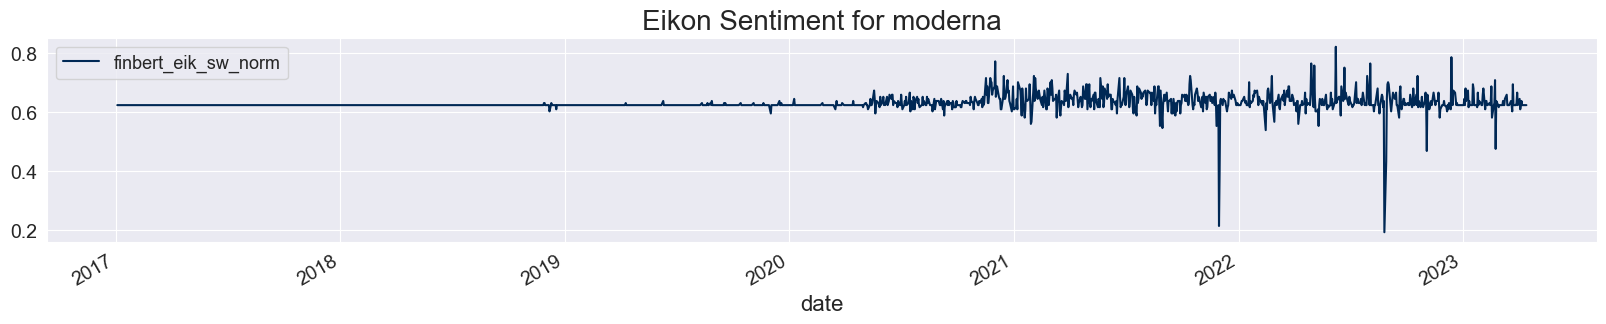

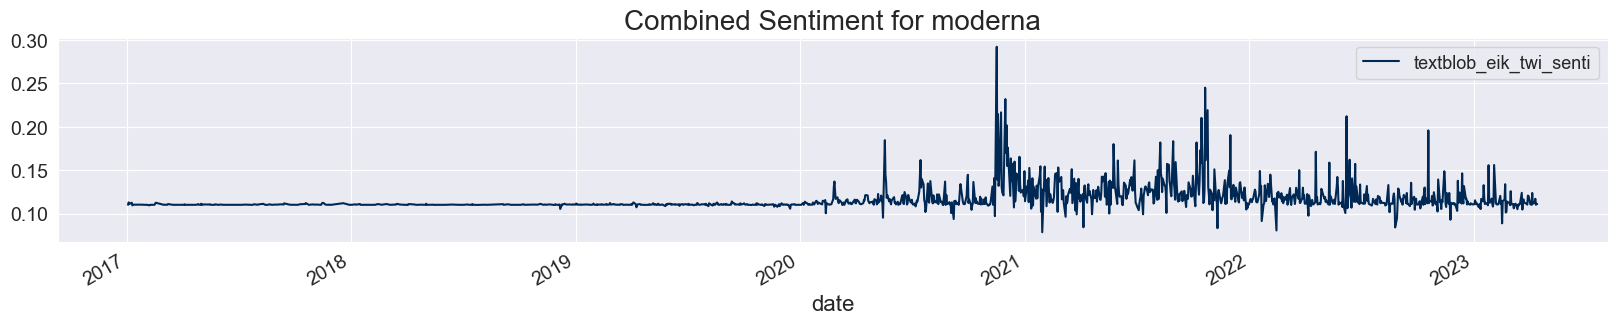

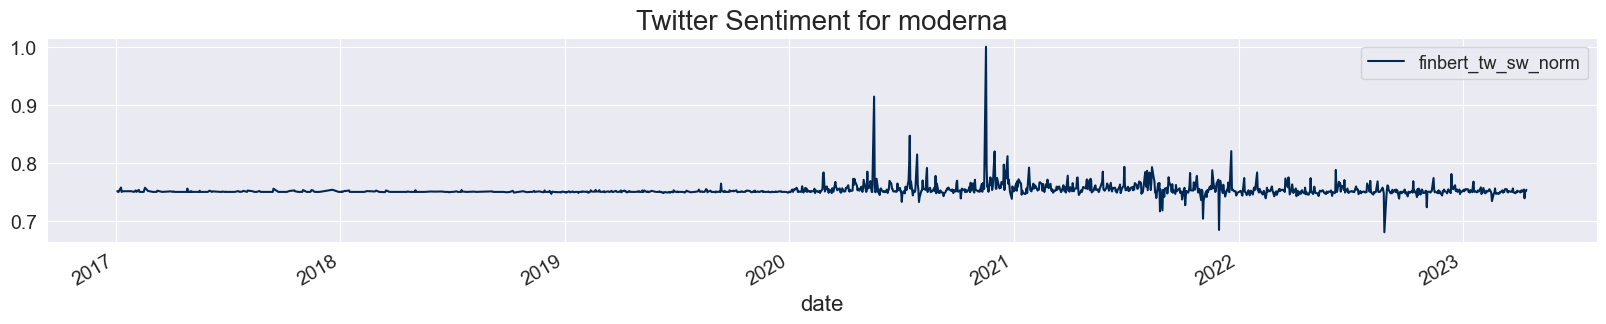

In [268]:
company = "moderna"
quick_test_moderna = master_table_news_sentiment[master_table_news_sentiment["company"] == "moderna"]
quick_test_moderna = quick_test_moderna.set_index(quick_test_moderna.date)
quick_test_moderna[["finbert_eik_sw_norm"]].plot(figsize = (20,3), legend = True,title = "Eikon Sentiment for {}".format(company))
quick_test_moderna[["textblob_eik_twi_senti"]].plot(figsize = (20,3), legend = True, title = "Combined Sentiment for {}".format(company))
quick_test_moderna[["finbert_tw_sw_norm"]].plot(figsize = (20,3), legend = True, title = "Twitter Sentiment for {}".format(company))

---

<Axes: title={'center': 'Combined Sentiment for apple'}, xlabel='date'>

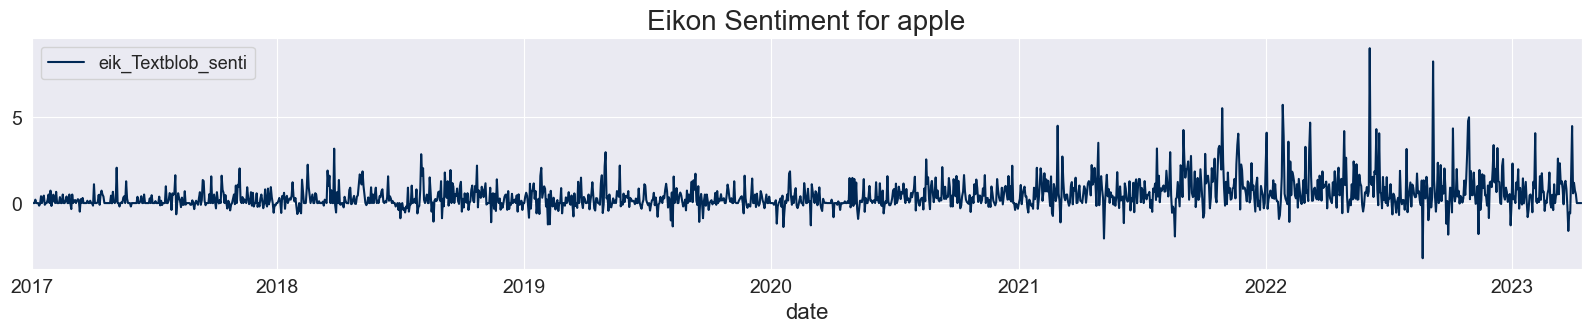

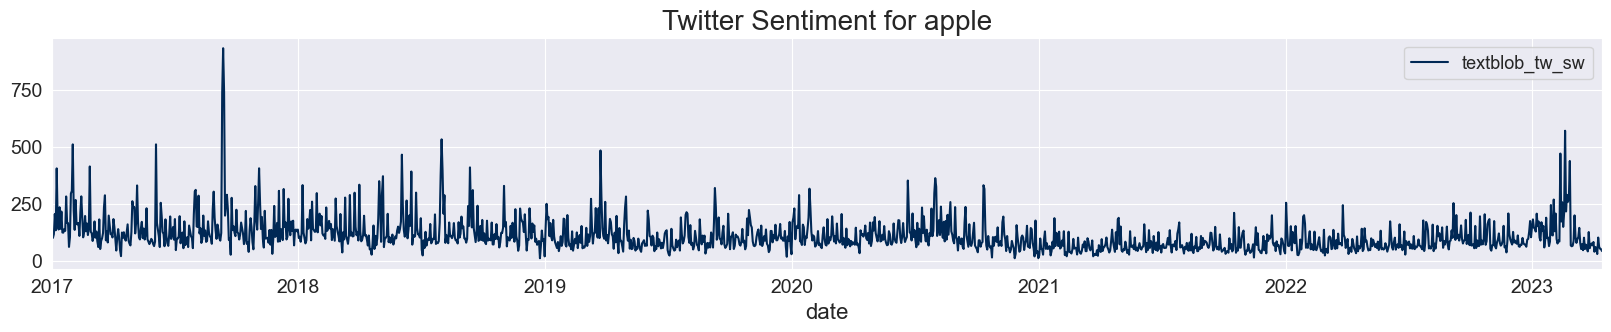

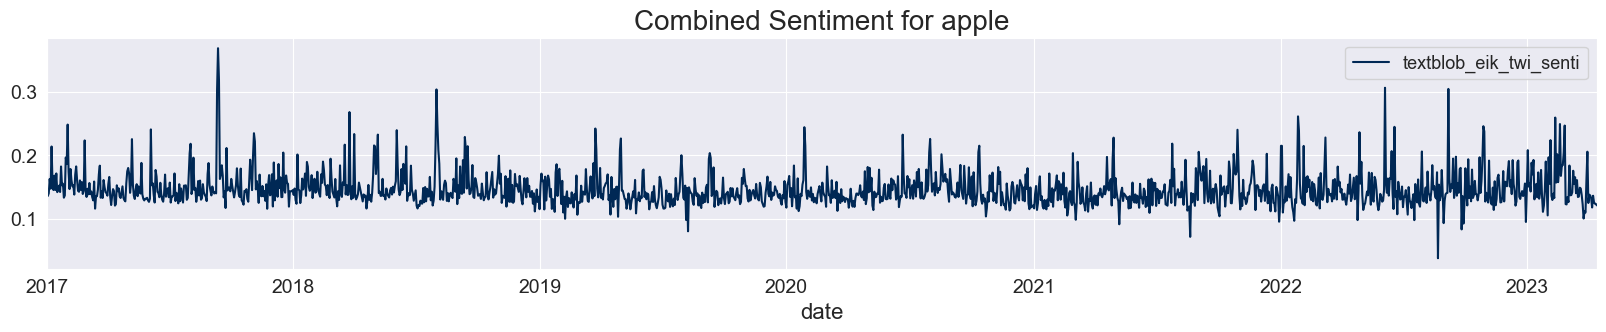

In [270]:
company = "apple"
quick_test_moderna = master_table_news_sentiment[master_table_news_sentiment["company"] == company]
quick_test_moderna = quick_test_moderna.set_index(quick_test_moderna.date)
quick_test_moderna[["eik_Textblob_senti"]].plot(figsize = (20,3), legend = True,title = "Eikon Sentiment for {}".format(company))
quick_test_moderna[["textblob_tw_sw"]].plot(figsize = (20,3), legend = True, title = "Twitter Sentiment for {}".format(company))
quick_test_moderna[["textblob_eik_twi_senti"]].plot(figsize = (20,3), legend = True, title = "Combined Sentiment for {}".format(company))

<Axes: title={'center': 'Combined Sentiment for tesla'}, xlabel='date'>

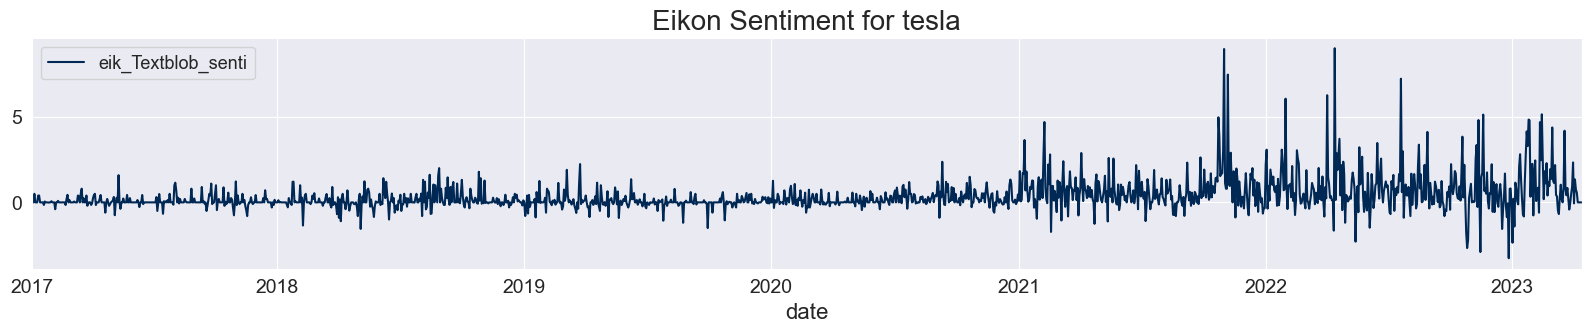

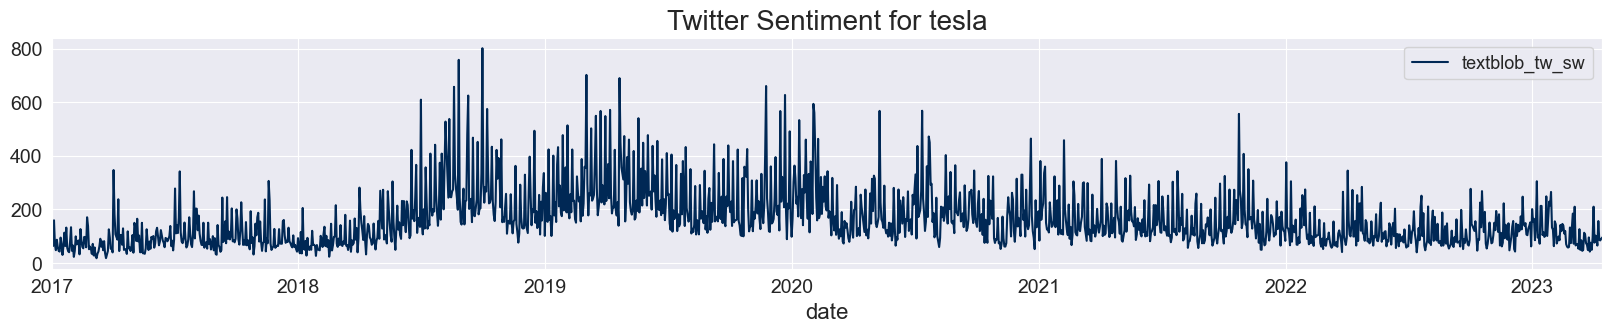

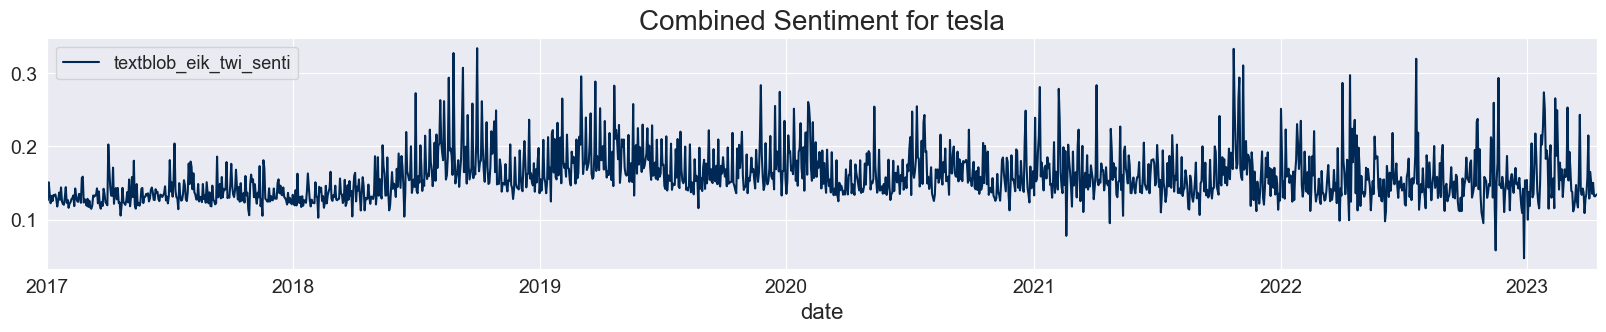

In [271]:
company = "tesla"
quick_test_moderna = master_table_news_sentiment[master_table_news_sentiment["company"] == company]
quick_test_moderna = quick_test_moderna.set_index(quick_test_moderna.date)
quick_test_moderna[["eik_Textblob_senti"]].plot(figsize = (20,3), legend = True,title = "Eikon Sentiment for {}".format(company))
quick_test_moderna[["textblob_tw_sw"]].plot(figsize = (20,3), legend = True, title = "Twitter Sentiment for {}".format(company))
quick_test_moderna[["textblob_eik_twi_senti"]].plot(figsize = (20,3), legend = True, title = "Combined Sentiment for {}".format(company))